In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import matplotlib.pyplot as plt

# Solutions for Practical I

## Problem 1

### (a) Generate $10^6$ uniformly distributed variables on unit interval [0, 1], and check the mean and variance.

In [2]:
%%time
uniform_rvs = np.random.uniform(size = 10**6)

CPU times: user 10.2 ms, sys: 3.29 ms, total: 13.5 ms
Wall time: 12.4 ms


-- The mean and variance of a U(0, 1) variable is $\frac{1}{2}$ and $\frac{1}{12}$

-- Sample mean 5% confidence interval $[\mu-\frac{\sigma}{\sqrt{n}}\alpha_{97.5\%}, \mu + \frac{\sigma}{\sqrt{n}}\alpha_{97.5\%}]$, $\alpha$ is the standard Gaussian quantile.

-- sample variance confidence interval $[\sigma-\frac{Std(\sigma)}{\sqrt{n}}\xi_1, \sigma + \frac{Std(\sigma)}{\sqrt{n}}\xi_2]$, $\xi_1$ and $\xi_2$ are corresponding $\chi^2$ quantiles

In [3]:
a = np.sqrt(1/12)/np.sqrt(len(uniform_rvs)) * stats.norm.ppf(0.975)
0.5 - a, 0.5 + a

(0.49943420713296194, 0.5005657928670381)

Confidence interval for mean: 

In [4]:
uniform_rvs.mean(), uniform_rvs.var()

(0.49982093135140826, 0.083371991656453)

### (b) Covariance matrix and Cholesky factorization, to generate $1^2$ pairs of correlated Gaussian variables

In [5]:
Sigma = np.array([[4, 1],
                  [1, 4]])
L = np.linalg.cholesky(Sigma)

In [6]:
L.dot(L.T)

array([[4., 1.],
       [1., 4.]])

In [7]:
norm_rvs = np.random.normal(size = 2*10**6).reshape(2, -1)

Sample covariance matrix 

In [8]:
norm_rvs.dot(norm_rvs.T)/norm_rvs.shape[1]

array([[1.00065435e+00, 3.32495932e-04],
       [3.32495932e-04, 1.00011969e+00]])

Converted by L, so that $Y = LX$ has covariance $\Sigma = LL^T$

In [9]:
norm_rvs_new = L.dot(norm_rvs)
norm_rvs_new.dot(norm_rvs_new.T)/norm_rvs_new.shape[1]

array([[4.0026174, 1.0019421],
       [1.0019421, 4.0012563]])

### (c) Repeat previous exercise using PCA of $\Sigma$

- The PCA $\Sigma \cdot V = V\cdot\Lambda$, where $V$ is the matrix of column eigen vectors, and $\Lambda$ is the diagonal matrix of eigen values.

- Take $Y = V\sqrt{\Lambda}X$, then $Y$ has variance $\Sigma$.

In [10]:
eigval, eigvec = np.linalg.eig(Sigma)
eigval = np.diag(eigval)

In [11]:
Sigma.dot(eigvec)

array([[ 3.53553391, -2.12132034],
       [ 3.53553391,  2.12132034]])

In [12]:
eigvec.dot(np.diag(eigval))

array([1.41421356, 5.65685425])

In [13]:
norm_rvs_pca = eigvec.dot(np.sqrt(eigval)).dot(norm_rvs)

In [14]:
norm_rvs_pca.dot(norm_rvs_pca.T)/norm_rvs_pca.shape[1]

array([[4.00052766, 1.00145634],
       [1.00145634, 4.00310316]])

### (d) Repeat to see how many pairs we can generate in 1 minute

In [15]:
norm = stats.norm

In [16]:
# n = 1000000
# def generateNormal():

#      w=np.zeros((2,n));

#      for i in range(n):

#          temp=np.matmul(L, [norm.ppf(np.random.uniform(0,1)), norm.ppf(np.random.uniform(0,1))]);

#          w[0,i]=temp[0];

#          w[1,i]=temp[1];
# t_end = time.time() + 1;

# count=0;

# while time.time() < t_end:

#      generateNormal();

#      count+=1;

In [17]:
import time

In [163]:
%%time
M = 10**9
rv_norms_testing_time = np.random.normal(size = M)
rrr = rv_norms_testing_time.reshape(2, -1)
xxx = eigvec.dot(np.sqrt(eigval)).dot(rrr)

CPU times: user 39.7 s, sys: 32.1 s, total: 1min 11s
Wall time: 1min 6s


In [101]:
# %%time
# M = 2 * 10**9
# rv_norms_testing_time = np.random.normal(size = M)
# rv_norms_testing_time

CPU times: user 51.7 s, sys: 5.64 s, total: 57.3 s
Wall time: 1min 2s


In [102]:
# %%time
# rrr = rv_norms_testing_time.reshape(2, -1)
# xxx = eigvec.dot(np.sqrt(eigval)).dot(rrr)
# xxx.dot(xxx.T)/xxx.shape[1]

CPU times: user 29 s, sys: 1min 10s, total: 1min 39s
Wall time: 2min 14s


array([[3.99964775, 0.99999852],
       [0.99999852, 3.99984234]])

## Problem 2

$ \bar{f} = \mathbb{E}[f(U)]=\int_0^1f(U)dU $

$f(x) = x\cos(\pi x)$

### (a) Analytically the mean equals $\bar{f}=\frac{\pi\sin(\pi)+\cos(\pi)-1}{\pi^2}=-\frac{2}{\pi^2}\approx-0.20264236728467552$

### Analytical variance:
$\sigma^2 = \int_0^1(f(U)-\bar{f})^2dU = \frac{1}{6} + \frac{1}{4\pi^2} - \frac{4}{\pi^4}$

In [18]:
exact_mean = (np.sin(np.pi)*np.pi + np.cos(np.pi) - 1)/np.pi**2
exact_var  = 1/6 + 1/4/np.pi**2 - 4/np.pi**4

In [19]:
f = lambda x:x * np.cos(np.pi*x)

### (b & c) CDF plotting

From CLT, the normal distribution is $N(\mu, \frac{\sigma^2}{m})$

In [20]:
def simulateEmpiricalCDFs(M, N, f, 
                          exact_mean = None,
                          exact_var = None,
                          plot_title = 'Empirical CDF of Simulated Mean',):
    uniform_matrix = np.random.uniform(size = M * N).reshape(M, -1)
    f_vals = f(uniform_matrix)
    Y_m    = np.sort(f_vals.mean(axis = 1))
    C_m    = [(m - 0.5)/M for m in np.arange(1, M + 1, 1)]
    D_m    = pd.DataFrame(np.array([Y_m, C_m]).T,
                          columns = ['empirical', 'CDF from Simulation'])

    x_vals   = np.arange(Y_m.min(), Y_m.max(), 0.0001)

    exact_mean = Y_m.mean() if exact_mean is None else exact_mean
    exact_var = f_vals.var(ddof = 1) if exact_var is None else exact_var
    std_clt = np.sqrt(exact_var/N)
    
    norm_cdf = stats.norm(loc = exact_mean, 
               scale = std_clt).cdf(x_vals)
    D_norm = pd.DataFrame(np.array([x_vals, norm_cdf]).T)
    D_norm.columns = [0, 'CDF from CLT']

    ax = D_m.plot(*D_m.columns, )
    D_norm.plot(0, 1, ax = ax, title = plot_title)

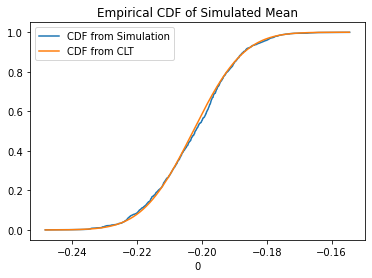

In [21]:
simulateEmpiricalCDFs(1000, 1000, f, exact_mean, exact_var)

### Summary of (c): The empirical distribution converges to the normal distribution from CLT as N tends to infinity

### (d) Convergence plot w.r.t. to N

In [22]:
def simulateMeans(N, f, exact_mean = None, **kwargs):
    unifs = np.random.uniform(size = N)
    rvs   = f(unifs, **kwargs)
    mean, var   = rvs.mean(), rvs.var(ddof = 1)
    exact_mean  = mean if exact_mean is None else exact_mean
    low, high = mean - 3 * np.sqrt(var/N), mean + 3 * np.sqrt(var/N)
    return mean, low, high

In [23]:
def empiricalConfidenceIntervals(f, exact_mean, n_simulations = np.arange(1000, 101000, 1000),
                                 simulateFunction = simulateMeans,
                                 **kwargs):
    estimators_N  = []
    conf_lows     = []
    conf_highs    = []

    for N in n_simulations:
        mean, low, high = simulateFunction(N, f, exact_mean = exact_mean, **kwargs)
        estimators_N.append(mean)
        conf_lows.append(low)
        conf_highs.append(high)

    df_sum = pd.DataFrame(np.array([n_simulations,
                                    estimators_N, conf_lows, conf_highs]).T,
                          columns = ['N_Samples', 'Estimator', 'Confidence_Low', 'Confidence_High'])
    exact_mean = mean if exact_mean is None else exact_mean
    df_sum['True_Mean'] = exact_mean
    df_sum.set_index('N_Samples', inplace = True)
    return df_sum

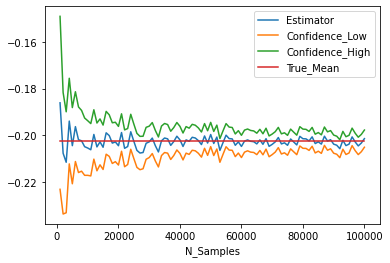

In [24]:
df_sum = empiricalConfidenceIntervals(f, exact_mean)
df_sum.plot()

## Problem 3. Estimation of a European call option price

In [27]:
r, sigma, S0, K, T = 0.05, 0.2, 100, 100, 1
call_true = european_call(S0, r, sigma, K, T)
call_true

10.45058357218555

In [26]:
def european_call(S0, r, sigma, K, T):
    log = np.log(S0/(K*np.exp(-r*(T))))
    sig = 1/2 * sigma * np.sqrt(T)
    d1  = log/sigma/np.sqrt(T) + sig
    d2  = log/sigma/np.sqrt(T) - sig
    return S0 * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

In [28]:
def payoff_call(U, S0 = S0, r = r, sigma = sigma, K = K, T = T):
    ST = S0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * stats.norm.ppf(U))
    return np.exp(-r * T) * (ST - K) * (ST - K >= 0)

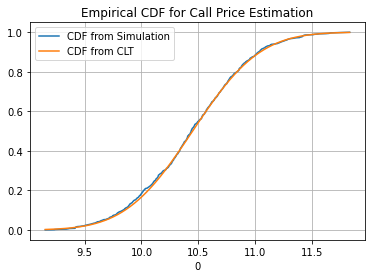

In [29]:
simulateEmpiricalCDFs(M = 1000, N = 1000, f = payoff_call,
                      exact_mean = call_true, exact_var = None,
                      plot_title = 'Empirical CDF for Call Price Estimation')
plt.grid()

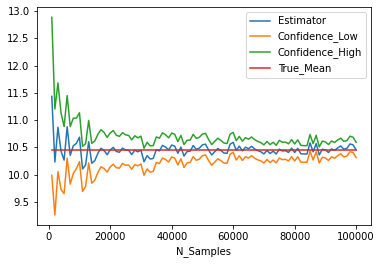

In [30]:
df_sum_call = empiricalConfidenceIntervals(payoff_call, call_true)
df_sum_call.plot()

## Problem 4. Variance Reduction for European Call Estimation

### (a) Antithetic variable

In [33]:
uniforms = np.random.uniform(size = 1000)
rvs_positive = payoff_call(uniforms, sigma = sigma)
rvs_negative = payoff_call(uniforms, sigma = -sigma)
np.corrcoef(rvs_positive, rvs_negative)

array([[ 1.        , -0.50271562],
       [-0.50271562,  1.        ]])

In [34]:
def payoff_call_antithetic(U, S0 = S0, r = r, 
                           sigma = sigma, K = K, T = T):
    return 0.5 * payoff_call(U, S0, r, sigma, K, T) + 0.5 * payoff_call(U, S0, r, -sigma, K, T)

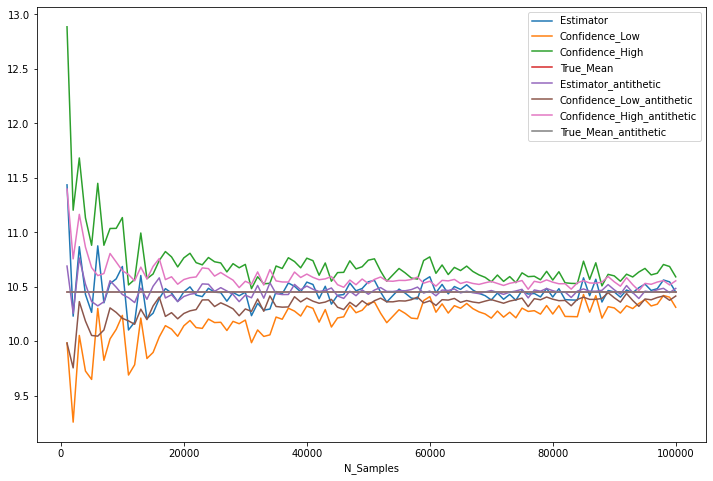

In [35]:
df_sum_call_antithetic = empiricalConfidenceIntervals(payoff_call_antithetic,
                                                      call_true)
df_sum_call_antithetic.rename(columns = lambda x:x + '_antithetic',
                              inplace = True)
ax = df_sum_call.plot(figsize = (12, 8))
df_sum_call_antithetic.plot(ax = ax)

### (b) Control Variates $f(S) = \exp(-rT)S(T)$

In [36]:
def f_call_control_variate(U, lambd = 0.5, S0 = S0, r = r, sigma = sigma, K = K, T = T):
    ST = S0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * stats.norm.ppf(U))
    
    payoff  = np.exp(-r * T) * (ST - K) * (ST - K >= 0)
    control = lambd * (np.exp(-r*T)*ST - S0)
    return payoff - control

In [37]:
def f_and_g(U, S0 = S0, r = r, sigma = sigma, K = K, T = T):
    ST = S0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * stats.norm.ppf(U))
    
    f  = np.exp(-r * T) * (ST - K) * (ST - K >= 0)
    g  = (np.exp(-r*T)*ST - S0)
    return f, g

#### An optimal $\lambda$ for control variate

In [38]:
ff, gg = f_and_g(uniforms)

In [39]:
lambd_opt = np.cov(ff, gg)[0, 1]/np.var(gg)
lambd_opt

0.6677016368106271

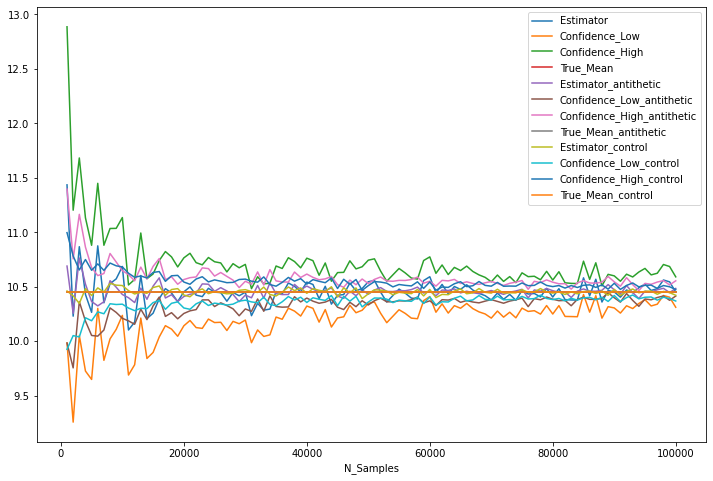

In [40]:
df_sum_call_control = empiricalConfidenceIntervals(f_call_control_variate,
                                                   call_true, 
                                                   lambd = lambd_opt)
df_sum_call_control.rename(columns = lambda x:x + '_control',
                              inplace = True)

ax = df_sum_call.plot(figsize = (12, 8))
df_sum_call_antithetic.plot(ax = ax)
df_sum_call_control.plot(ax = ax)


## Problem 5. Importance Sampling for Digital Put Options


$P = \exp(-rT)H(K - S_T)$

### Analytical value = Derivative w.r.t. Strike K

In [466]:
K = 50

In [467]:
def digitalPutPrice(S0 = S0, r = r, sigma = sigma, K = K, T = T):
    log = np.log(S0/(K*np.exp(-r*(T))))
    sig = 1/2 * sigma * np.sqrt(T)
    d1  = log/sigma/np.sqrt(T) + sig
    d2  = log/sigma/np.sqrt(T) - sig
    return np.exp(-r * T) * stats.norm.cdf(-d2)

digitalPut_exact = digitalPutPrice()
digitalPut_exact

0.00014244451054998028

In [468]:
def payOffDigitalPut(U, S0 = S0, r = r, sigma = sigma, K = K, T = T):
    ST = S0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * stats.norm.ppf(U))
    return np.exp(-r * T) * (K - ST >= 0)

### (a) Value estimation without importance sampling

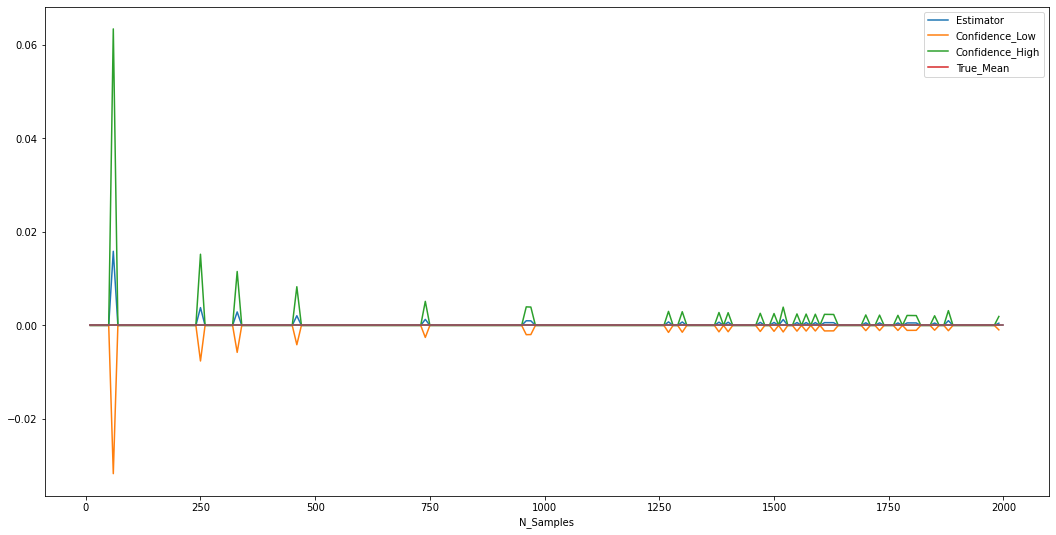

In [622]:
df_digitalPut = empiricalConfidenceIntervals(payOffDigitalPut,
                                             digitalPut_exact,
                                             n_simulations = np.arange(10, 2000, 10))
ax = df_digitalPut.plot(figsize = (18, 9))
ax.plot([10, 2000], [digitalPut_exact * 0.9] * 2)
ax.plot([10, 2000], [digitalPut_exact * 1.1] * 2)

Around 1000 sample sizes reach 10% accuracy

### (b) With importance sampling, making half of the sample stock price below/above the strike.

- Under risk-neutral measure $\mathbb{Q}$, the price dynamic is $dS_t = S_t(r dt + \sigma dW_t^Q)$

- Now seek a new probability measure $\mathbb{P}^a$, such that $dS_t = S_t(a dt + \sigma dW_t^a)$, where $W^a$ is a Brownian motion under $\mathbb{P}^a$, $dW_t^a = dW_t^Q - \frac{a-r}{\sigma} dt$.

- Set $\mathbb{P}^a(S_T\geq K) = \frac{1}{2}$, one can solve for $a = \frac{1}{T}\log(\frac{K}{S_0}) - \frac{1}{2}\sigma^2$

- Density $\frac{dP^a}{dQ}|_{T} = \exp(\frac{r-a}{\sigma}T-(\frac{r-a}{2\sigma})^2W_T^a)$

- Option price = $\mathbb{E^a}[\exp(-rT)\frac{dP^a}{dQ}|_{T}\mathbb{I}(K - S_T(W_T^a))^+]$

In [615]:
S0 = 100
K = 50
T = 1
r = 0.05
sigma = 0.2
log = np.log(S0/(K*np.exp(-r*(T))))
sig = 1/2 * sigma * np.sqrt(T)
d1  = log/sigma/np.sqrt(T) + sig
d2  = log/sigma/np.sqrt(T) - sig
thres = stats.norm.cdf(d2)

In [616]:
new_drift = 0.5 * sigma**2 + 1/T*np.log(K/S0)

In [617]:
a = new_drift
U = np.random.uniform(size = 10000)
ST = S0 * np.exp((a - sigma**2/2) * T + sigma * np.sqrt(T) * stats.norm.ppf(U))
density = np.exp((r-a)/sigma * np.sqrt(T) * stats.norm.ppf(U) - ((r-a)/sigma)**2/2 * T)

In [618]:
def payOffDigitalPutImportanceSampling(U, S0 = S0, r = r, sigma = sigma, K = K, T = T, a = new_drift):
    ST = S0 * np.exp((a - sigma**2/2) * T + sigma * np.sqrt(T) * stats.norm.ppf(U))
    density = np.exp((r-a)/sigma * np.sqrt(T) * stats.norm.ppf(U) - ((r-a)/sigma)**2/2 * T)
    return np.exp(-r * T) * (K - ST >= 0) * density

In [619]:
df_ImpSamp = empiricalConfidenceIntervals(payOffDigitalPutImportanceSampling, digitalPut_exact, 
                                  simulateFunction = simulateMeans,
                                  n_simulations = np.arange(10, 2000, 10))

In [620]:
df_ImpSamp.rename(columns = lambda x:x + '_ImportanceSampling', inplace = True)

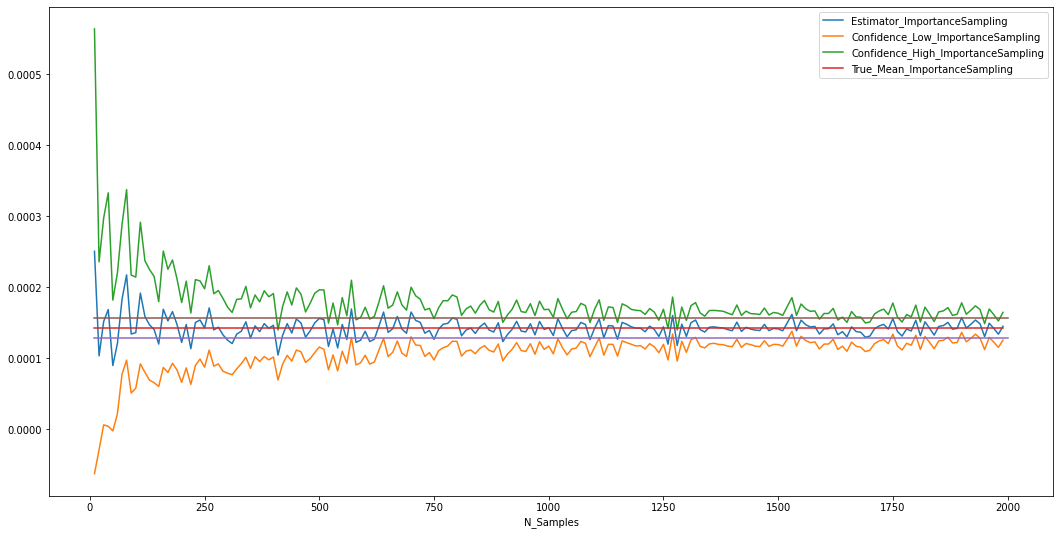

In [621]:
ax = df_ImpSamp.plot(figsize = (18, 9))
#df_digitalPut.plot(ax = ax)

ax.plot([10, 2000], [digitalPut_exact * 0.9] * 2)
ax.plot([10, 2000], [digitalPut_exact * 1.1] * 2)

Conclusion: Seems only need 750 samples to reach 10% accuracy

## Problem 6. Bumping method for European Call Option

### (a) Computing Delta and Vega using 'bumping' method

- Bumping: $\hat{Y} = \frac{1}{2N\Delta\theta}\sum_{i=1}^N(X^{(i)}(\theta + \Delta\theta) - X^{(i)}(\theta - \Delta\theta))$

- For a call option, the Delta = $N(d_1)$, Vega = $Ke^{-rT}\phi(d_2)\sqrt{T}$.

#### a-0: Analytical result:

In [233]:
Delta_true = stats.norm.cdf(d1)
Vega_true  = K * np.exp(-r * T) * stats.norm.pdf(d2) * np.sqrt(T)
Delta_true, Vega_true

(0.6368306511756188, 37.5240346916938)

#### a-1: Delta and Vega using different random samples: Variance is relatively large. One can try running the following cells and see how estimated Delta and Vega vary

In [240]:
N = 10000
delta_S0 = 1

delta_sigma = 0.01

In [241]:
mean_minus, low_minus, high_minus = simulateMeans(N, payoff_call, S0 = S0 - delta_S0)
mean_plus, low_plus, high_plus = simulateMeans(N, payoff_call, S0 = S0 + delta_S0)

Delta_estim = (mean_plus - mean_minus)/(2 * delta_S0)
print('Estimated Delta = {}'.format(Delta_estim))

Estimated Delta = 0.6218114071764074


In [242]:
mean_minus, low_minus, high_minus = simulateMeans(N, payoff_call, sigma = sigma - delta_sigma)
mean_plus, low_plus, high_plus = simulateMeans(N, payoff_call, sigma = sigma + delta_sigma)

Vega_estim = (mean_plus - mean_minus)/(2 * delta_sigma)
print('Estimated Vega = {}'.format(Vega_estim))

Estimated Vega = 27.014030500584774


##### a-1 Varaince Compare, generate M = 10000 estimates and compute their variance

In [142]:
def calculateSensitivityEstimatorStd(M, paramName, paramValue, paramDelta, functionToSimulate = payoff_call):
    estimatorList = []
    kwargs_minus = {paramName: paramValue - paramDelta}
    kwargs_plus  = {paramName: paramValue + paramDelta}
    for i in range(M):
        mean_minus, low_minus, high_minus = simulateMeans(N, functionToSimulate, **kwargs_minus)
        mean_plus,  low_plus, high_plus   = simulateMeans(N, functionToSimulate, **kwargs_plus)
        sensVal = (mean_plus - mean_minus)/(2 * paramDelta)
        estimatorList.append(sensVal)
    return np.std(estimatorList), estimatorList

In [108]:
M = 10000

In [129]:
deltaStdDifferentSample = calculateSensitivityEstimatorStd(M, 'S0', S0, delta_S0)

In [130]:
vegaStdDifferentSample  = calculateSensitivityEstimatorStd(M, 'sigma', sigma, delta_sigma)

In [135]:
print('The Std of 10000 Delta estimators using different random sample is {}'.format(deltaStdDifferentSample[0]))

The Std of 10000 Delta estimators using different random sample is 0.10422924112806652


In [136]:
print('The Std of 10000 Vega estimators using different random sample is {}'.format(vegaStdDifferentSample[0]))

The Std of 10000 Vega estimators using different random sample is 10.413075906180827


#### a-2: Delta and Vega using same set of random samples: Variance is much smaller, using same N and bump size

In [138]:
def sensitivityCall_SameSample(U, baseValue = 100, bump_size = 1, paramName = 'S0', ):
    var_plus  = {paramName: baseValue + bump_size}
    var_minus = {paramName: baseValue - bump_size}
    return payoff_call(U, **var_plus) - payoff_call(U, **var_minus)

In [139]:
mean, low, high = simulateMeans(N, sensitivityCall_SameSample, 
                                baseValue = S0, bump_size = delta_S0, paramName = 'S0')
Delta_estim_same = mean/(2 * delta_S0)
print('Estimated Delta with same sample = {}'.format(Delta_estim_same))

Estimated Delta with same sample = 0.6403209078375354


In [140]:
mean, low, high = simulateMeans(N, sensitivityCall_SameSample, 
                                baseValue = sigma, bump_size = delta_sigma, paramName = 'sigma')
Vega_estim_same = mean/(2 * delta_sigma)
print('Estimated Vega with same sample = {}'.format(Vega_estim_same))


Estimated Vega with same sample = 36.893482671805906


In [144]:
def calculateSensitivityEstimatorStd_SameSample(M, paramName, paramValue, paramDelta, 
                                                functionToSimulate = sensitivityCall_SameSample):
    estimatorList = []
    kwargs = {'paramName': paramName,
              'baseValue': paramValue,
              'bump_size': paramDelta}
    for i in range(M):
        mean, low, high = simulateMeans(N, functionToSimulate, **kwargs)
        sensVal = mean/(2 * paramDelta)
        estimatorList.append(sensVal)
    return np.std(estimatorList), estimatorList

In [147]:
deltaStd_SametSample = calculateSensitivityEstimatorStd_SameSample(M, 'S0', S0, delta_S0, 
                                                           functionToSimulate = sensitivityCall_SameSample)

In [148]:
vegaStd_SametSample  = calculateSensitivityEstimatorStd_SameSample(M, 'sigma', sigma, delta_sigma,
                                                           functionToSimulate = sensitivityCall_SameSample)

In [149]:
print('The Std of 10000 Delta estimators using SAME random sample is {}'.format(deltaStd_SametSample[0]))

The Std of 10000 Delta estimators using SAME random sample is 0.005684671037854045


In [150]:
print('The Std of 10000 Vega estimators using different random sample is {}'.format(vegaStd_SametSample[0]))

The Std of 10000 Vega estimators using different random sample is 0.7629025793957178


#### Variance plot w.r.t. N omitted, as one can easily observe the variance difference by running the above cells, and see the output of Std computing function above

### (b) Computing Delta and Vega using IPA ('pathwise' method)

#### The importance is to write out the derivative in analytical form $\frac{\partial f}{\partial \theta}$

- $\frac{\partial f}{\partial \theta} = \frac{\partial f}{\partial S_T}\frac{\partial S_T}{\partial \theta}$

- For a call option, $f$ can be approximated by $f(S) = (S-K)\Phi(\frac{S - K}{\epsilon}) + \frac{\epsilon}{\sqrt{2\pi}}\exp(-\frac{(S-K)^2}{2\epsilon^2})$

- $\frac{\partial f}{\partial S} = \Phi(\frac{S - K}{\epsilon}) + \frac{S - K}{\epsilon}n(\frac{S - K}{\epsilon}) - \frac{1}{\sqrt{2\pi}}\exp(-\frac{(S-K)^2}{2\epsilon^2})\frac{S-K}{\epsilon}$

- For Delta:
$\frac{\partial S_T}{\partial S_0} = \frac{S_T}{S_0}$

- For Vega:
$\frac{\partial S_T}{\partial \sigma} = S_T(W_T-\sigma T)$


#### b-1: Computing Delta by IPA

In [151]:
epsilon = 1e-3
N = 10000

In [152]:
def DF_DS_IPA_Delta(U, S0 = S0, r = r, sigma = sigma, K = K, T = T, epsilon = epsilon):
    ST = S0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * stats.norm.ppf(U))
    SK = (ST - K)/epsilon
    df_ds = stats.norm.cdf(SK) + SK * stats.norm.pdf(SK) - 1/np.sqrt(2*np.pi)*np.exp(-0.5 * SK**2) * SK
    df_ds = np.exp(-r * T) * df_ds
    return df_ds * ST/S0

In [153]:
mean, low, high = simulateMeans(N, DF_DS_IPA_Delta)
print('IPA Estimated Delta with same sample = {}'.format(mean))

IPA Estimated Delta with same sample = 0.6256297188570056


##### b-1 Variance of M = 10000 estimators

In [156]:
estimators_IPA_Delta = []
for i in range(M):
    mean, low, high = simulateMeans(N, DF_DS_IPA_Delta)
    estimators_IPA_Delta.append(mean)

print('Std of PA Estimated Delta with same sample = {}'.format(np.std(estimators_IPA_Delta)))

Std of PA Estimated Delta with same sample = 0.005758137251340933


#### b-2: Computing Vega by IPA

In [154]:
def DF_DS_IPA_Vega(U, S0 = S0, r = r, sigma = sigma, K = K, T = T, epsilon = epsilon):
    ST = S0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * stats.norm.ppf(U))
    SK = (ST - K)/epsilon
    df_ds = stats.norm.cdf(SK) + SK * stats.norm.pdf(SK) - epsilon/np.sqrt(2*np.pi)*np.exp(-0.5 * SK**2) * SK/epsilon
    return df_ds * ST * (stats.norm.cdf(U) * np.sqrt(T) - sigma * T)

In [155]:
mean, low, high = simulateMeans(N, DF_DS_IPA_Vega)
print('IPA Estimated Vega with same sample = {}'.format(mean))

IPA Estimated Vega with same sample = 38.33486699980745


##### b-2 Variance of M = 10000 estimators

In [157]:
estimators_IPA_Vega = []
for i in range(M):
    mean, low, high = simulateMeans(N, DF_DS_IPA_Vega)
    estimators_IPA_Vega.append(mean)

print('Std of PA Estimated Delta with same sample = {}'.format(np.std(estimators_IPA_Vega)))

Std of PA Estimated Delta with same sample = 0.3539786458197209


## Conclusion: IPA achieves optimal estiation for sensitivities, especially the Vega estimation. The Std of IPA is only more than half of Std of bumping method using same random samples.